# Trump Twitter Sentiment Analysis
Here I train a shallow RNN on a public dataset of tweets made to airlines which are classified as positive, neutral and negative. I discard the neutral tweets for simplicity. I use the RNN model (which has an over 90% test accuracy) to classify the sentiment of Donald Trump's tweets: 1 being positive and 0 negative. For each day between 2017-01-01 to present day I find the mean average sentiment. From Yahoo finance I import OHLC data of the S&P500 index and calculate close-open and high-low values for each trading day ('-' = minus) and normalize each set of values. I then check if Trump's sentiment appears to affect/predict S&P500 daily prices.

In [5]:
import html
import numpy as np
import GetOldTweets3 as got
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM
from keras.layers import Conv1D

Imports. GetOldTweets3 to get the tweets as the twitter API has limits on the number of tweets you can pull. Pandas for data manipulation. Tensorflow and Keras for the NLP. 

In [33]:
username = 'realDonaldTrump'
since = '2017-01-01'
tweetCriteria = got.manager.TweetCriteria().setUsername(username).setSince(since)
tweets = got.manager.TweetManager.getTweets(tweetCriteria)
user_tweets = [[tweet.date, tweet.text] for tweet in tweets]

Pull in his tweets since the beginning of 2017. He was formally inaugurate on the 20th of January 2017.

In [41]:
dates = [user_tweets[i][0].date() for i in range(len(user_tweets))]
tweets = [user_tweets[i][1] for i in range(len(user_tweets))]
df = pd.DataFrame(data=tweets, index=dates, columns=['Tweets'])
df

,Tweets
2020-07-12,"No, Radical Left anarchists, agitators, looter..."
2020-07-12,"Thank you to J.R. Majewski, a great Air Force ..."
2020-07-12,"...rounds, no problem. When I play, Fake News ..."
2020-07-12,I know many in business and politics that work...
2020-07-12,We have now built 240 Miles of new Border Wall...
...,...
2017-01-02,Various media outlets and pundits say that I t...
2017-01-02,"@CNN just released a book called ""Unprecedente..."
2017-01-02,"Chicago murder rate is record setting - 4,331 ..."
2017-01-02,"Well, the New Year begins. We will, together, ..."


GetOldTweets3 returns a list of lists containing the tweet date in position 0 and the tweet's text in position 1. Make a list of dates and tweets and create a dataframe making the dates the index.

In [42]:
os.chdir('/Users/maxjackson/Downloads/17_742210_bundle_archive')
data = pd.read_csv('Tweets.csv', usecols=['airline_sentiment','text'])
data.columns = ['sentiment','text']
data.head()

,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Import only the relevant columns from the train set.

In [43]:
def remover(string):
    x = string.split()
    return ' '.join([word for word in x if '@' not in word])

data['text'] = data['text'].apply(remover)
data = data[data['sentiment'] != 'neutral'].reset_index(drop=True)
data.head()

,sentiment,text
0,positive,plus you've added commercials to the experienc...
1,negative,"it's really aggressive to blast obnoxious ""ent..."
2,negative,and it's a really big bad thing about it
3,negative,seriously would pay $30 a flight for seats tha...
4,positive,"yes, nearly every time I fly VX this “ear worm..."


Remove any twitter usernames and reset the index.

In [44]:
X = [html.unescape(txt) for txt in data['text'].values]
y = np.array([0 if elem == 'negative' else 1 for elem in data['sentiment']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

The unescape(  ) function computes a new string in which hexadecimal escape sequences are replaced with the character that it represents e.g. apostrophes-  ( ' ) are read in as ( \' ) but unescape turns it back to ( ' ). The next line turns negative to 0 and positive to 1. Split the data into 20% test and 80% train.

In [45]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Instantiate the keras inbuilt Tokenizer which assigns numbers to unique words in a sentence. OOV = out-of-vocabulary and is the value given to words not within the 5000 tokenized words. num_words defines the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.

In [46]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Take the max length sentence we expect as 100 which will be sufficient since tweets are restricted to 280 characters. Encoded sentences are lists of numbers the same length as the number of words in the sentence. Padding makes all lists length 100 by adding 0's to the end.

In [47]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/Users/maxjackson/Downloads/32801_42887_bundle_archive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

From https://nlp.stanford.edu/projects/glove/: GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [48]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Create the embedding matrix of size (length of the number of words tokenized) x100. The embedding matrix takes the discrete tokenized word values and represents them as a vector in continuous space. Embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space.

In [57]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.92):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, input_shape=(100,)))
model.add(Dropout(0.6))
model.add(Dense(128))
model.add(Dropout(0.6))
model.add(Dense(128))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2, callbacks=[callbacks])

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/15
58/58 [==============================] - 13s 232ms/step - loss: 0.6248 - acc: 0.7909 - val_loss: 0.5115 - val_acc: 0.7818
Epoch 2/15
58/58 [==============================] - 15s 267ms/step - loss: 0.4924 - acc: 0.7951 - val_loss: 0.4498 - val_acc: 0.7818
Epoch 3/15
58/58 [==============================] - 12s 210ms/step - loss: 0.4107 - acc: 0.7951 - val_loss: 0.3956 - val_acc: 0.7818
Epoch 4/15
58/58 [==============================] - 12s 205ms/step - loss: 0.3746 - acc: 0.8290 - val_loss: 0.3732 - val_acc: 0.8663
Epoch 5/15
58/58 [==============================] - 13s 229ms/step - loss: 0.3240 - acc: 0.8768 - val_loss: 0.3340 - val_acc: 0.8728
Epoch 6/15
58/58 [==============================] - 12s 214ms/step - loss: 0.3042 - acc: 0.8845 - val_loss: 0.3188 - val_acc: 0.8787
Epoch 7/15
58/58 [==============================] - 14s 241ms/step - loss: 0.2796 - acc: 0.8917 - val_loss: 0.2924 - val_acc: 0.8841
Epoch 8/15
58/58 [==============================] - 12s 213ms/step - 

- Define a callback to cease training in case an accuracy threshold is hit. This threshold is not hit in this case. 

- Create a neural network of architecture: embedding layer -> Long short-term memory with 128 units -> Densely connected 128 unit layer -> Densely connected 128 unit layer -> Output layer. 

- Use dropout with prob 0.6 of turning off a given unit to reduce overfitting of the training data. 

- Use a binary crossentropy loss function (equivalently log loss as used in logistic regression) and an adam optimiser with learning rate 0.0001. 

- Use minibatches of size 128 which increase training time but reduces overfitting. Validate on 20% of the data.

- Use 15 epochs which is sufficient for this data but for other sets the loss may decrease much slower in which case hundred or more epochs may be required. 

We got very similar over 90% accuracies on the validation and test sets so the model has low variance and quite low bias

In [50]:
def pad(text): 
  l = []
  for elem in tokenizer.texts_to_sequences(text):
    l.append(elem+(100-len(elem))*[0])
  return array(l)

Define a function to manually pad lists.

In [51]:
preds = model.predict_classes(pad(df['Tweets'].values))
df['Preds']=preds
df

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,Tweets,Preds
2020-07-12,"No, Radical Left anarchists, agitators, looter...",0
2020-07-12,"Thank you to J.R. Majewski, a great Air Force ...",1
2020-07-12,"...rounds, no problem. When I play, Fake News ...",0
2020-07-12,I know many in business and politics that work...,0
2020-07-12,We have now built 240 Miles of new Border Wall...,0
...,...,...
2017-01-02,Various media outlets and pundits say that I t...,0
2017-01-02,"@CNN just released a book called ""Unprecedente...",0
2017-01-02,"Chicago murder rate is record setting - 4,331 ...",0
2017-01-02,"Well, the New Year begins. We will, together, ...",1


Use the model to predict the sentiment of Trump's tweets. We briefly observe 'Thank you to J.R. Majewski, a great Air Force ...	' got classified as positive and the tweet starting 'No, Radical Left anarchists, agitators, looter...' got classified negative which are reassuring.

In [52]:
import os
os.chdir('/usr/local/lib/python3.7/site-packages')

In [53]:
from yahoo_fin import stock_info as si

# pulls historical OHLC data into a pandas data frame
oc, hl = si.get_data('^GSPC')[['open', 'adjclose']].loc['2017-01-01':,], si.get_data('^GSPC')[['high', 'low']].loc['2017-01-01':,]

oc['Diff']=oc['adjclose']-oc['open']
hl['Diff']=hl['high']-hl['low']

display(oc)
display(hl)

,open,adjclose,Diff
2017-01-03,2251.570068,2257.830078,6.260010
2017-01-04,2261.600098,2270.750000,9.149902
2017-01-05,2268.179932,2269.000000,0.820068
2017-01-06,2271.139893,2276.979980,5.840088
2017-01-09,2273.590088,2268.899902,-4.690186
...,...,...,...
2020-07-06,3155.290039,3179.719971,24.429932
2020-07-07,3166.439941,3145.320068,-21.119873
2020-07-08,3153.070068,3169.939941,16.869873
2020-07-09,3176.169922,3152.050049,-24.119873


,high,low,Diff
2017-01-03,2263.879883,2245.129883,18.750000
2017-01-04,2272.820068,2261.600098,11.219971
2017-01-05,2271.500000,2260.449951,11.050049
2017-01-06,2282.100098,2264.060059,18.040039
2017-01-09,2275.489990,2268.899902,6.590088
...,...,...,...
2020-07-06,3182.590088,3155.290039,27.300049
2020-07-07,3184.149902,3142.929932,41.219971
2020-07-08,3171.800049,3136.530029,35.270020
2020-07-09,3179.780029,3115.699951,64.080078


Pull in S&P500 OHLC data since the first of January 2017 as two separate dataframes; one with O/C data and the other with H/L data. Create 'diff' columns for each dataframe. Use 'adjclose' to account for any stock splits.

In [54]:
oc['Diff']=(oc['Diff']-oc['Diff'].min())/(oc['Diff'].max()-oc['Diff'].min())
hl['Diff']=(hl['Diff']-hl['Diff'].min())/(hl['Diff'].max()-hl['Diff'].min())

display(oc)
display(hl)

,open,adjclose,Diff
2017-01-03,2251.570068,2257.830078,0.537271
2017-01-04,2261.600098,2270.750000,0.547193
2017-01-05,2268.179932,2269.000000,0.518593
2017-01-06,2271.139893,2276.979980,0.535829
2017-01-09,2273.590088,2268.899902,0.499674
...,...,...,...
2020-07-06,3155.290039,3179.719971,0.599657
2020-07-07,3166.439941,3145.320068,0.443263
2020-07-08,3153.070068,3169.939941,0.573699
2020-07-09,3176.169922,3152.050049,0.432962


,high,low,Diff
2017-01-03,2263.879883,2245.129883,0.069526
2017-01-04,2272.820068,2261.600098,0.034531
2017-01-05,2271.500000,2260.449951,0.033741
2017-01-06,2282.100098,2264.060059,0.066227
2017-01-09,2275.489990,2268.899902,0.013013
...,...,...,...
2020-07-06,3182.590088,3155.290039,0.109263
2020-07-07,3184.149902,3142.929932,0.173955
2020-07-08,3171.800049,3136.530029,0.146303
2020-07-09,3179.780029,3115.699951,0.280197


Map the 'diff' columns between 0 and 1.

In [55]:
from datetime import date
start = date(2017,1,1)
end = date(2017,7,1)
deltaperiod = 6
from dateutil.relativedelta import relativedelta
dates = []
for i in range(7):
    dates.append(start+relativedelta(months=i*deltaperiod))
dates.append(pd.to_datetime('today').date())
dates

[datetime.date(2017, 1, 1),
 datetime.date(2017, 7, 1),
 datetime.date(2018, 1, 1),
 datetime.date(2018, 7, 1),
 datetime.date(2019, 1, 1),
 datetime.date(2019, 7, 1),
 datetime.date(2020, 1, 1),
 datetime.date(2020, 7, 12)]

Make a list of dates every 6 months up until the current date.

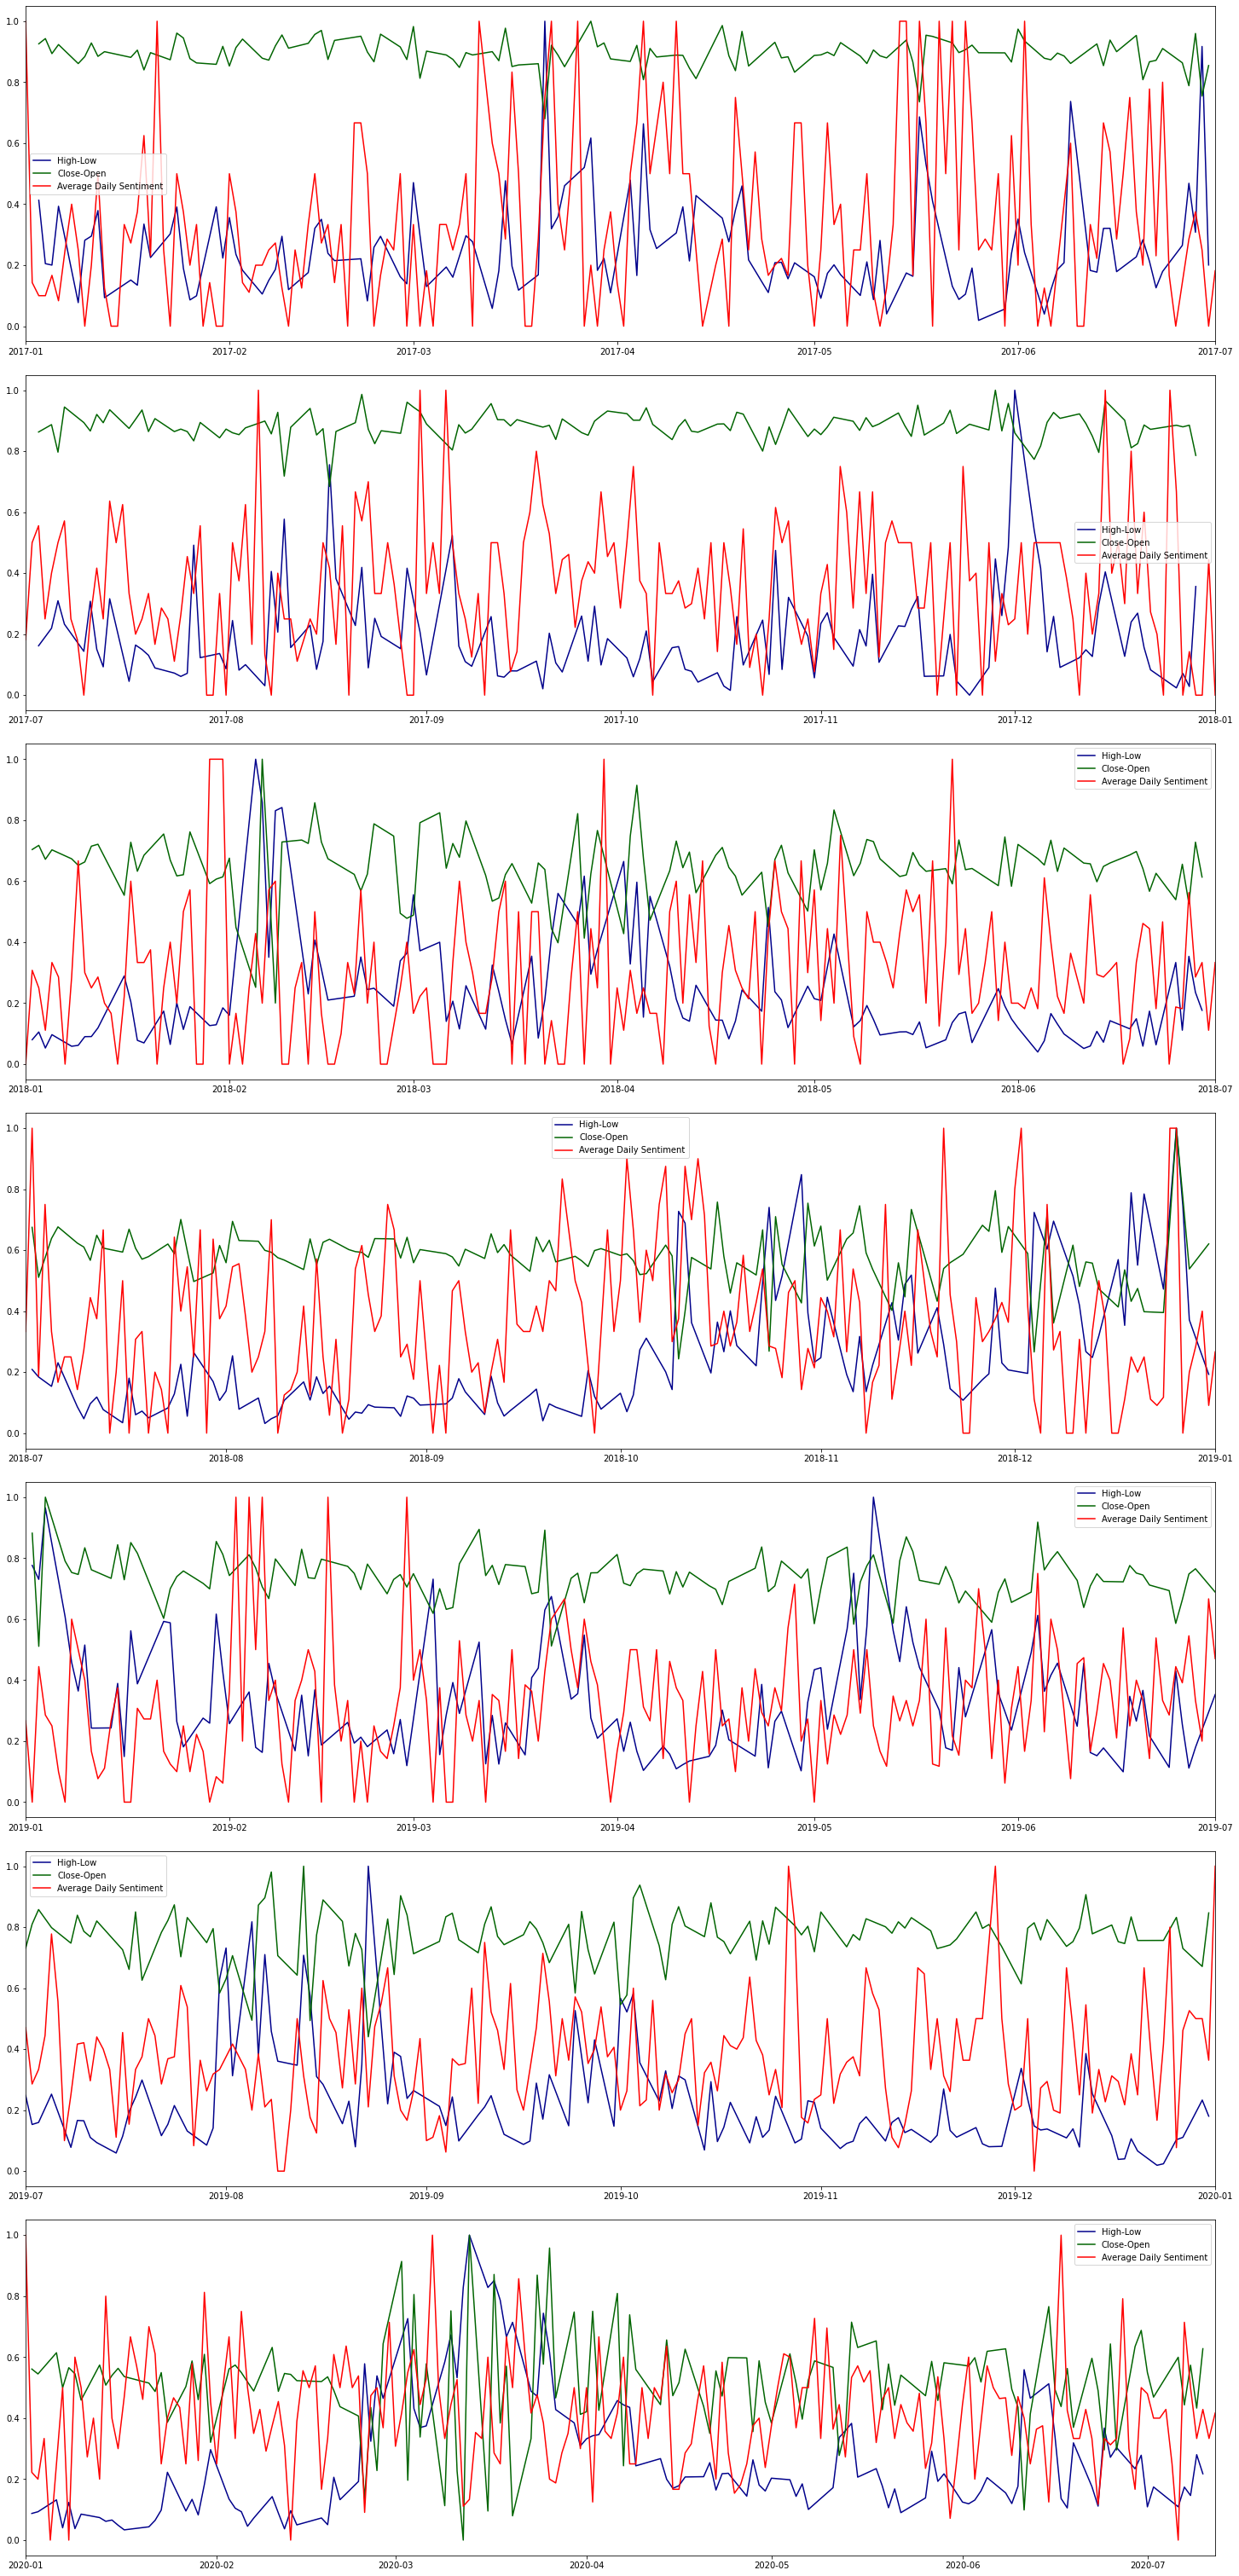

In [60]:
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(7, 1, figsize=(25, 55))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(len(dates)-1):
    datoc = oc['Diff'].loc[dates[i]:dates[i+1],]/oc['Diff'].loc[dates[i]:dates[i+1],].max()
    dathl = hl['Diff'].loc[dates[i]:dates[i+1],]/hl['Diff'].loc[dates[i]:dates[i+1],].max()
    datsent = df.groupby(level=0).mean().loc[dates[i]:dates[i+1],]
    dathl.plot(subplots=True, ax=axs[i], label='High-Low', color='darkblue')
    datoc.plot(subplots=True, ax=axs[i], label='Close-Open', color='darkgreen')
    datsent.plot(subplots=True, ax=axs[i], label='Average Daily Sentiment', color='red')
    axs[i].legend(labels=['High-Low', 'Close-Open', 'Average Daily Sentiment'],loc='best')


Scale the high-low data so that it has a max value of 1 so is on a more similar scale to the average daily sentiment data. The close-open data is fairly central and not very volatile so scaling would just move the whole line toward one which isn't very useful.